In [2]:
!pip install scipy

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from scipy.signal.windows import gaussian

def praat_striation_spectrogram(
    filepath,
    sr=None,
    window_length_sec=0.003,  # shorter window for voicing detail
    hop_length_sec=0.001,     # high time resolution
    max_freq=5000,
    dynamic_range=60,
    preemph_cutoff=50,
    cmap='gray_r',
    dpi=200,
    show_plot=True,
    save_path=None
):
    # Load audio
    y, sr = librosa.load(filepath, sr=sr)

    # Pre-emphasis
    pre_emph_coeff = np.exp(-2 * np.pi * preemph_cutoff / sr)
    y = np.append(y[0], y[1:] - pre_emph_coeff * y[:-1])

    # Window/hop
    win_length = int(window_length_sec * sr)
    hop_length = int(hop_length_sec * sr)
    n_fft = 2 ** int(np.ceil(np.log2(win_length)))
    window = gaussian(win_length, std=win_length / 6)

    # STFT
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length,
                     win_length=win_length, window=window)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

    # Clip to dynamic range
    S_db[S_db < (np.max(S_db) - dynamic_range)] = np.max(S_db) - dynamic_range

    # Display
    times = np.linspace(0, len(y) / sr, S_db.shape[1])
    freqs = np.linspace(0, sr / 2, S_db.shape[0])

    if show_plot or save_path:
        fig, ax = plt.subplots(figsize=(12, 4), dpi=dpi)
        img = ax.imshow(S_db,
                        origin='lower',
                        aspect='auto',
                        interpolation='nearest',  # <- CRUCIAL for detail
                        cmap=cmap,
                        extent=[times[0], times[-1], freqs[0], freqs[-1]])

        ax.set_title("Praat-style Spectrogram (Striation-focused)")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Frequency (Hz)")
        ax.set_ylim(0, max_freq)

        fig.colorbar(img, ax=ax, label='dB')
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
        if show_plot:
            plt.show()

    return S_db, sr


In [8]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

example = librosa.example('libri1')

In [9]:
example

'/root/.cache/librosa/5703-47212-0000.ogg'

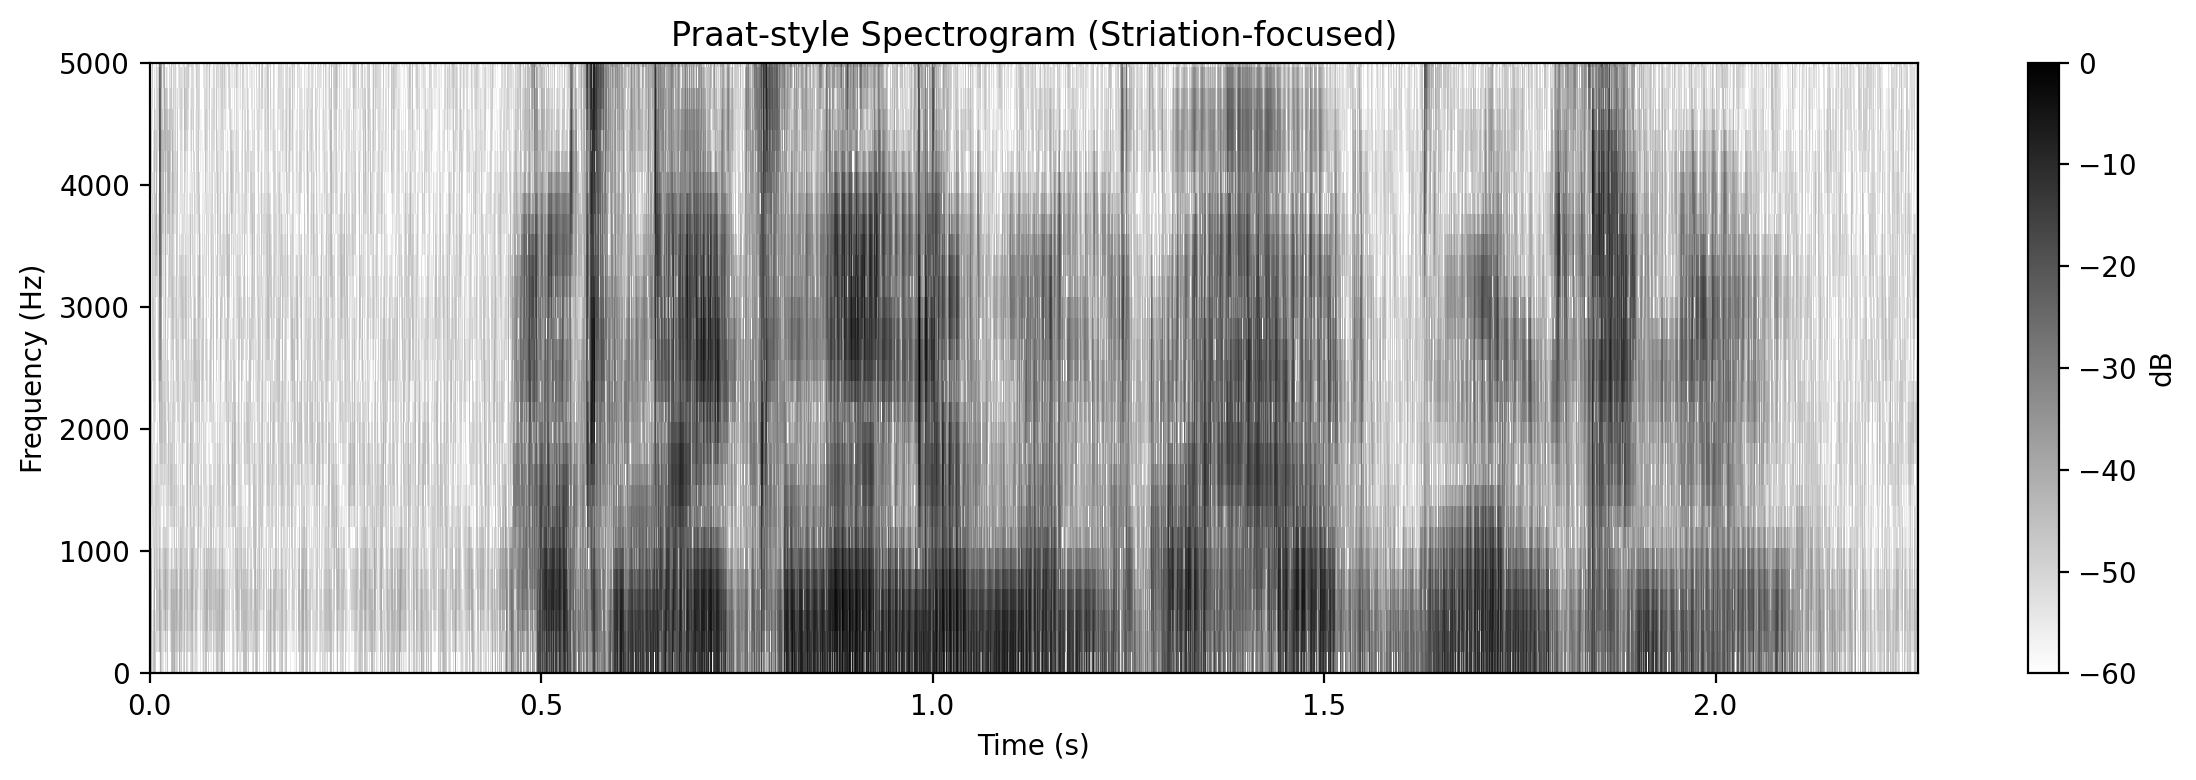

(array([[-45.07371265, -44.85438372, -56.04109187, ..., -42.68017915,
         -59.07762538, -49.61122104],
        [-43.86768985, -43.6282035 , -52.93879452, ..., -42.48273338,
         -55.53738049, -48.97483437],
        [-41.97790526, -41.44267815, -48.66576405, ..., -42.39131515,
         -52.0115122 , -47.82061638],
        ...,
        [-48.21335686, -60.        , -60.        , ..., -60.        ,
         -60.        , -60.        ],
        [-47.97970448, -59.04123968, -60.        , ..., -60.        ,
         -60.        , -60.        ],
        [-47.86925585, -58.18684907, -60.        , ..., -60.        ,
         -60.        , -60.        ]]),
 44100)

In [41]:
praat_striation_spectrogram("/content/testclip.wav", save_path="thing")

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy.signal.windows import gaussian
from scipy.ndimage import zoom

# --------------------------
# STFT-BASED SPECTROGRAM
# --------------------------
def praat_stft_spectrogram(
    filepath,
    sr=None,
    window_length_sec=0.003,
    hop_length_sec=0.001,
    max_freq=5000,
    dynamic_range=60,
    preemph_cutoff=50,
    dpi=300,
    upsample_factor=2,
    cmap='gray_r'
):
    y, sr = librosa.load(filepath, sr=sr)

    # Pre-emphasis
    pre_emph_coeff = np.exp(-2 * np.pi * preemph_cutoff / sr)
    y = np.append(y[0], y[1:] - pre_emph_coeff * y[:-1])

    win_length = int(window_length_sec * sr)
    hop_length = int(hop_length_sec * sr)
    n_fft = 2 ** int(np.ceil(np.log2(win_length)))
    window = gaussian(win_length, std=win_length / 6)

    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length,
                     win_length=win_length, window=window)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

    # Dynamic range
    S_db[S_db < (np.max(S_db) - dynamic_range)] = np.max(S_db) - dynamic_range

    # Upsample spectrogram
    S_db_upsampled = zoom(S_db, zoom=(upsample_factor, upsample_factor), order=3)
    times_up = np.linspace(0, len(y) / sr, S_db_upsampled.shape[1])
    freqs_up = np.linspace(0, sr / 2, S_db_upsampled.shape[0])

    # Display
    plt.figure(figsize=(16, 4), dpi=dpi)
    plt.imshow(S_db_upsampled, origin='lower', aspect='auto',
               interpolation='none', cmap=cmap,
               extent=[times_up[0], times_up[-1], freqs_up[0], freqs_up[-1]])
    plt.title("High-Resolution STFT Spectrogram (Praat-style, Upsampled)")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.ylim(0, max_freq)
    plt.colorbar(label='dB')
    plt.tight_layout()
    plt.show()

    return S_db_upsampled, sr


# --------------------------
# CWT-BASED SPECTROGRAM
# --------------------------
def wavelet_spectrogram(
    filepath,
    sr=None,
    fmin=80,
    fmax=5000,
    voices_per_octave=48,
    dynamic_range=60,
    dpi=300,
    cmap='gray_r'
):
    import librosa.display

    y, sr = librosa.load(filepath, sr=sr)

    # CWT using the constant-Q transform
    cqt = librosa.cqt(y, sr=sr, fmin=fmin, n_bins=int(np.ceil(voices_per_octave * np.log2(fmax / fmin))),
                      bins_per_octave=voices_per_octave)
    C_db = librosa.amplitude_to_db(np.abs(cqt), ref=np.max)
    C_db[C_db < (np.max(C_db) - dynamic_range)] = np.max(C_db) - dynamic_range

    times = librosa.frames_to_time(np.arange(C_db.shape[1]), sr=sr)
    freqs = librosa.cqt_frequencies(C_db.shape[0], fmin=fmin, bins_per_octave=voices_per_octave)

    # Display
    plt.figure(figsize=(16, 4), dpi=dpi)
    plt.imshow(C_db, origin='lower', aspect='auto', interpolation='bicubic',
               cmap=cmap, extent=[times[0], times[-1], freqs[0], freqs[-1]])
    plt.title("Wavelet Spectrogram (CWT / Constant-Q)")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.ylim(0, fmax)
    plt.colorbar(label='dB')
    plt.tight_layout()
    plt.show()

    return C_db, sr


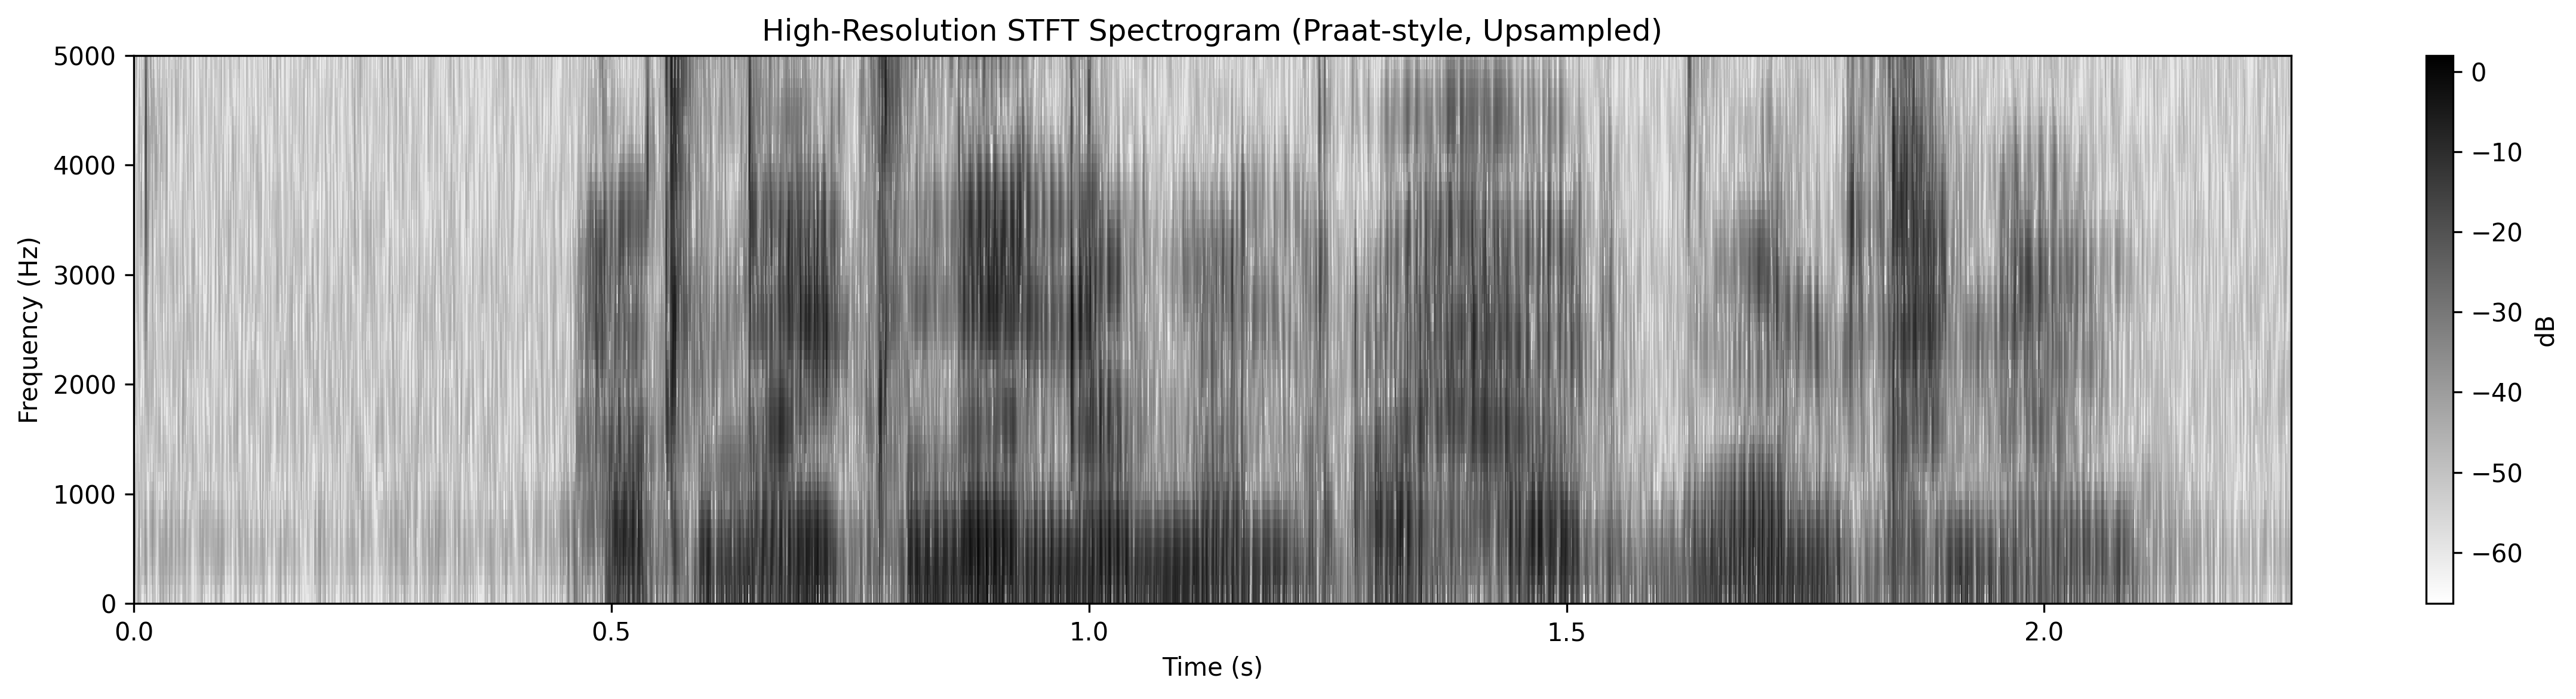

(array([[-45.07371265, -44.10446532, -44.85286499, ..., -59.07857579,
         -54.88156926, -49.61122104],
        [-44.71271424, -43.81453857, -44.50071608, ..., -57.90828617,
         -54.15923065, -49.4292372 ],
        [-43.87513964, -43.11681082, -43.63510684, ..., -55.55654426,
         -52.67538395, -48.97902916],
        ...,
        [-47.97891492, -52.32556712, -59.03429471, ..., -59.99994385,
         -59.96812192, -60.00000007],
        [-47.89885607, -52.00325083, -58.45405229, ..., -59.99994992,
         -59.9685616 , -60.00000223],
        [-47.86925585, -51.8580776 , -58.18478349, ..., -59.99994584,
         -59.96934427, -60.        ]]),
 44100)

In [43]:
praat_stft_spectrogram("/content/testclip.wav")

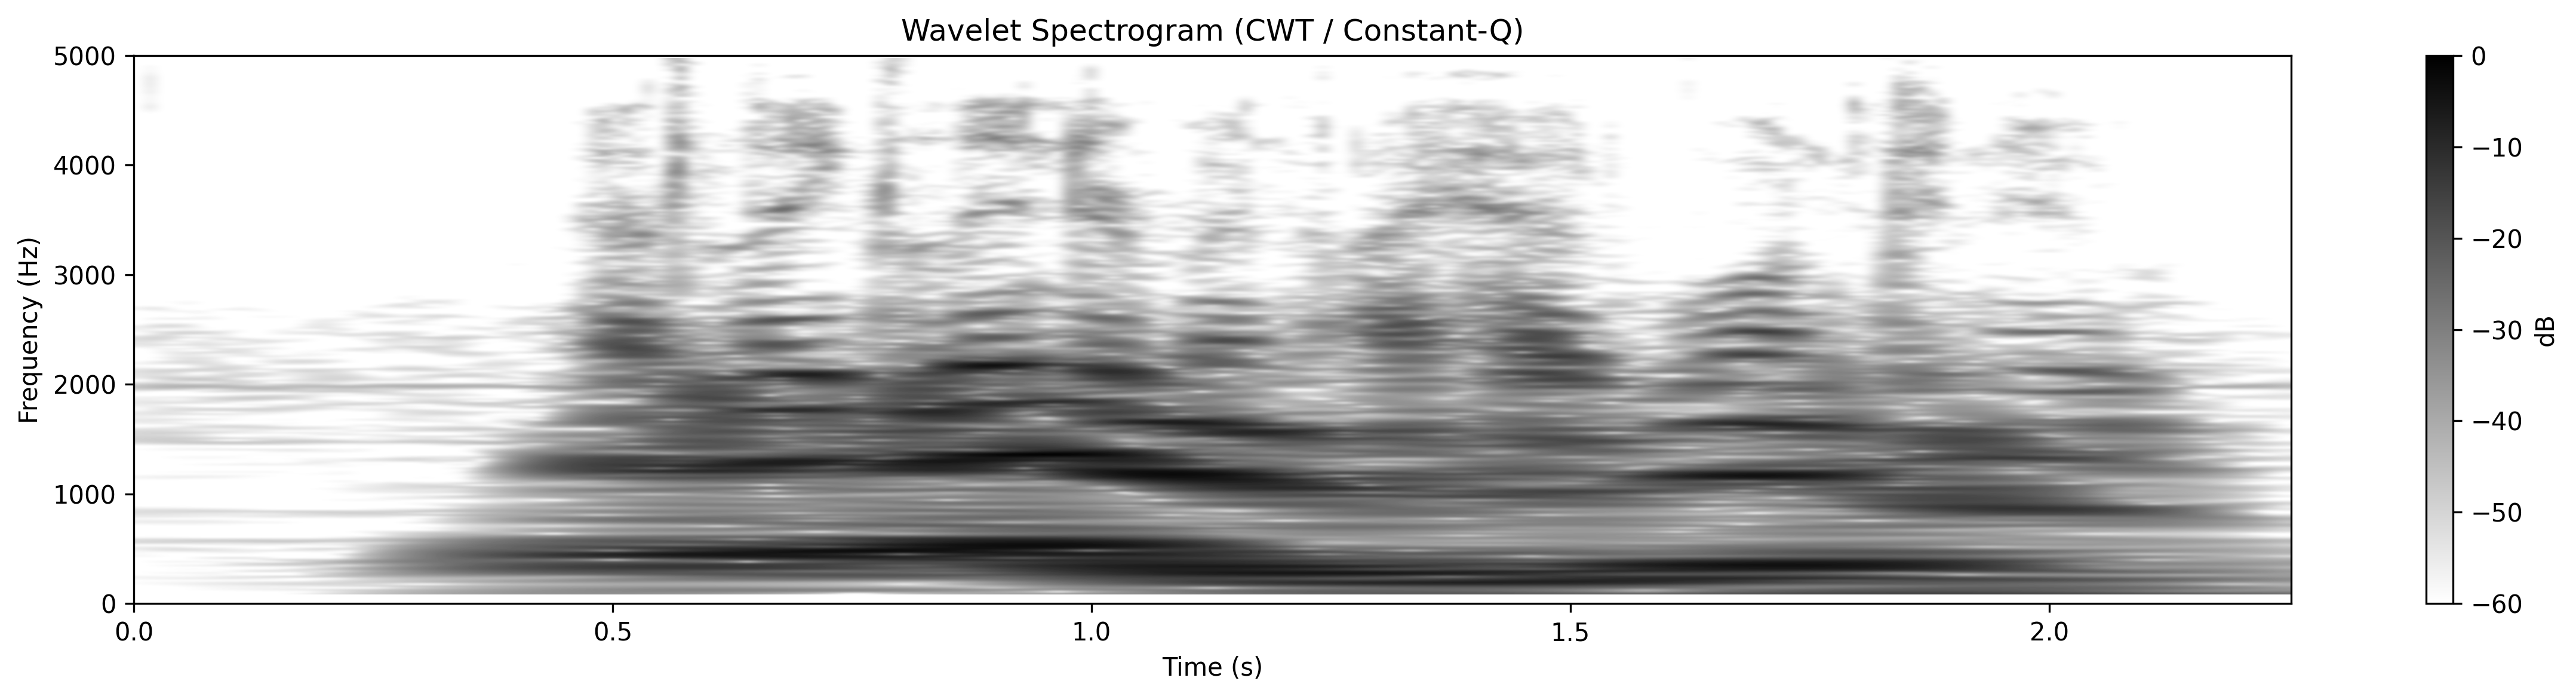

(array([[-60.      , -60.      , -60.      , ..., -23.8303  , -24.439774,
         -25.066795],
        [-60.      , -60.      , -60.      , ..., -32.11952 , -31.894463,
         -31.73713 ],
        [-60.      , -60.      , -60.      , ..., -34.984325, -35.229782,
         -35.37235 ],
        ...,
        [-60.      , -60.      , -60.      , ..., -60.      , -60.      ,
         -60.      ],
        [-60.      , -60.      , -60.      , ..., -60.      , -60.      ,
         -60.      ],
        [-60.      , -60.      , -60.      , ..., -60.      , -60.      ,
         -60.      ]], dtype=float32),
 44100)

In [44]:
wavelet_spectrogram("/content/testclip.wav")